# Collaborative Filtering Recommender System - Expedia Hotel dataset

## Import Libraries

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from fastai.collab import *

# set the environment path to find Recommenders
import sys
sys.path.append("../../")
import time
import os
import itertools
import pandas as pd
import numpy as np
import papermill as pm
import torch, fastai
from fastai.collab import EmbeddingDotBias, collab_learner, CollabDataBunch, load_learner

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.evaluation.python_evaluation import rmse, mae, rsquared, exp_var

In [302]:
user_id, item_id, rating, TIMESTAMP, PREDICTION, TITLE = 'user_id', 'item_id', 'rating', 'Timestamp', 'Prediction', 'title'

In [303]:
# top k items to recommend
TOP_K = 10
# Model parameters
N_FACTORS = 40
EPOCHS = 5

### Import Dataset

In [312]:
hotel_train_set = pd.read_csv('hotel_data/train.csv', sep=',', nrows=100000)
#movielens
#columns = ['user_id', 'item_id', 'rating', 'timestamp']
#ratings_df = pd.read_csv('movielens/u.data', sep='\t', names=columns)
#movie_titles = pd.read_csv("movielens/Movie_Id_Titles")
#movie_titles.head(n=2)
hotel_train_set.shape

(100000, 24)

In [313]:
# Merge 2 dataset together
#ratings_df = pd.merge(ratings_df,movie_titles,on='item_id')

In [315]:
ratings_df = hotel_train_set[['user_id','hotel_cluster','is_booking']]
ratings_df.head()

,user_id,hotel_cluster,is_booking
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [317]:
ratings_df.columns =['user_id', 'item_id', 'rating']

In [413]:
warnings.filterwarnings("ignore")
# make sure the IDs are loaded as strings to better prevent confusion with embedding ids
ratings_df[user_id] = ratings_df[user_id].astype('str')
ratings_df[item_id] = ratings_df[item_id].astype('str')
ratings_df.head()

,user_id,item_id,rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


### Split Train and Test

In [319]:
# Split the dataset
train_valid_df, test_df = python_stratified_split(
    ratings_df, 
    ratio=0.75, 
    min_rating=1, 
    filter_by="item", 
    col_user=user_id, 
    col_item=item_id
)

In [320]:
train_valid_df.head()

,user_id,item_id,rating
79647,322835,0,1
78944,320265,0,0
86856,348898,0,0
46181,170605,0,0
6200,36319,0,0


In [321]:
# fix random seeds to make sure our runs are reproducible
np.random.seed(101)
torch.manual_seed(101)
torch.cuda.manual_seed_all(101)

## Fast AI

### Training

In [322]:
# Turn the columns in category codes(to replace them with their codes for an Embedding layer)
# size of our validation set = 0.1 (or 0)
# we can add rating_name and user_name too.
# train on trainset
data = CollabDataBunch.from_df(train_valid_df, seed=42, valid_pct=0.1, 
                                      user_name='user_id', item_name='item_id', rating_name='rating')

In [323]:
data.show_batch()

user_id,item_id,target
132019,95,0.0
202461,42,0.0
202006,92,0.0
317154,83,0.0
202461,17,0.0


In [324]:
#Although ratings can only range from 1-5, we are setting the range of possible ratings to a range from 0 to 5.5
#that will allow the model to predict values around 1 and 5, which improves accuracy.
train_valid_df['rating'].min(),train_valid_df['rating'].max()

(0, 1)

In [325]:
# Lastly, we set a value for weight-decay for regularization.
learn = collab_learner(data, n_factors=N_FACTORS, y_range=[0,1], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(3450, 40)
  (i_weight): Embedding(101, 40)
  (u_bias): Embedding(3450, 1)
  (i_bias): Embedding(101, 1)
)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


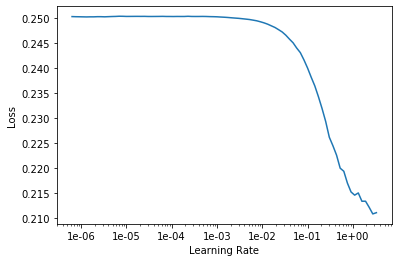

In [326]:
# find the perfect learning rates we can use the lr_find 
learn.lr_find()
# plot learning rate graph
learn.recorder.plot()

In [327]:
# Train our model using the fit_one_cycle method
learn.fit_one_cycle(EPOCHS, 5e-3) #1e-02) 

epoch,train_loss,valid_loss,time
0,0.081073,0.080614,00:08
1,0.076545,0.077439,00:09
2,0.072611,0.077430,00:09
3,0.066648,0.077621,00:09
4,0.069701,0.077665,00:09


In [328]:
#Save the learner so it can be loaded back later for inferencing / generating recommendations
learn.save('expedia_model')

In [329]:
learner = learn.load('expedia_model')

## Generating Recommendations

In [330]:
#Get all users and items that the model knows
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]
len(total_items),len(total_users)

(100, 3449)

In [331]:
#Get all users from the test set and remove any users that were know in the training set
test_users = test_df[user_id].unique()
test_users = np.intersect1d(test_users, total_users)
len(test_users)

3080

In [332]:
#Build the cartesian product of test set users and all items known to the model
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[user_id,item_id])

users_items.head()

,user_id,item_id
0,100025,0
1,100025,1
2,100025,10
3,100025,11
4,100025,12


In [333]:
#Lastly, remove the user/items combinations that are in the training set
#we don't want to propose a movie that the user has already watched.
training_removed = pd.merge(users_items, train_valid_df.astype(str), on=[user_id, item_id], how='left')
training_removed = training_removed[training_removed[rating].isna()][[user_id, item_id]]
training_removed.head()

,user_id,item_id
0,100025,0
1,100025,1
2,100025,10
4,100025,12
5,100025,13


### Score the model to find the top K recommendation

In [334]:
top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=user_id, 
                     item_col=item_id, 
                     prediction_col=PREDICTION)

In [335]:
top_k_scores.head()

,user_id,item_id,Prediction
69,100025,7,0.293561
11,100025,19,0.278298
5,100025,13,0.259783
39,100025,42,0.254088
10,100025,18,0.250379


## Evaluation

In [369]:
eval_precision = precision_at_k(test_df, top_k_scores, col_user=user_id, col_item=item_id, 
                    col_rating=rating, col_prediction=PREDICTION,
                                relevancy_method="top_k", k=TOP_K)

In [370]:
eval_recall = recall_at_k(test_df, top_k_scores, col_user=user_id, col_item=item_id, 
                    col_rating=rating, col_prediction=PREDICTION, 
                          relevancy_method="top_k", k=TOP_K)

In [ ]:
'''scores = score(learner, 
               test_df=test_df.copy(), 
               user_col=user_id, 
               item_col=item_id, 
               prediction_col=PREDICTION)
scores.head()'''

In [ ]:
'''eval_r2 = rsquared(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)
eval_rmse = rmse(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)
eval_mae = mae(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)'''

In [ ]:
'''print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, 
      "R squared:\t%f" % eval_r2, sep='\n')'''

### Prediction using get_preds

In [345]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [346]:
preds

tensor([0.0660, 0.0184, 0.0428,  ..., 0.0005, 0.0773, 0.1298])

In [347]:
y, y.shape

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), torch.Size([7500]))

### Evluation using Fastai library

In [348]:
print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "RMSE:\t%f" % root_mean_squared_error(preds, y),
      "MAE:\t%f" % mean_absolute_error(preds, y),
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, 
      "R squared:\t%f" % eval_r2, sep='\n')

Model:	CollabLearner
Top K:	10
RMSE:	0.278684
MAE:	0.146615
Precision@K:	0.034286
Recall@K:	0.050580
R squared:	0.336053


## ROC and AUC

ROC, as well as AUC, is a well known metric that is used for evaluating binary classification problem. It is similar in the case of binary rating typed recommendation algorithm where the "hit" accuracy on the relevant items is used for measuring the recommender's performance.
To demonstrate the evaluation method, the original data for testing is manipuldated in a way that the ratings in the testing data are arranged as binary scores, whilst the ones in the prediction are scaled in 0 to 1

In [380]:
top_k_scores

,user_id,item_id,Prediction
69,100025,7,0.293561
11,100025,19,0.278298
5,100025,13,0.259783
39,100025,42,0.254088
10,100025,18,0.250379
...,...,...,...
347670,99735,60,0.076614
347709,99735,96,0.072624
347633,99735,27,0.064859
347705,99735,92,0.063973


In [376]:
# Convert the original rating to 0 and 1.
df_true_bin = ratings_df.copy()
df_true_bin[rating] = ratings_df[rating] #df_true_bin[rating].apply(lambda x: 1 if x > 3 else 0)

In [383]:
from sklearn.preprocessing import minmax_scale
# Convert the predicted ratings into a [0, 1] scale.
df_pred_bin = top_k_scores.copy()
df_pred_bin[PREDICTION] = minmax_scale(df_pred_bin[PREDICTION].astype(float))

df_pred_bin.head()

,user_id,item_id,Prediction
69,100025,7,0.309420
11,100025,19,0.293332
5,100025,13,0.273816
39,100025,42,0.267814
10,100025,18,0.263905


In [388]:
# Calculate the AUC metric
from reco_utils.evaluation.python_evaluation import auc, logloss
auc_score = auc(
    df_true_bin,
    df_pred_bin,
    col_user = user_id,
    col_item = item_id,
    col_rating = rating,
    col_prediction = PREDICTION
)

In [389]:
print("The auc score is {}".format(auc_score))

The auc score is 0.6954456903284885


## Recommend hotel cluster for a user

In [349]:
rows = []
movies = list(df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(df.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(movies)):
    rows.append( dict({'name': names[i], 'item_id' : movies[i], 'user_id' : 9}))
test_data = pd.DataFrame(rows)

In [350]:
for idx, (score, name) in enumerate(sorted(zip(preds, names), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  0.64  for hotel cluster:  1477
Score:  0.58  for hotel cluster:  950
Score:  0.58  for hotel cluster:  1479
Score:  0.55  for hotel cluster:  176
Score:  0.5  for hotel cluster:  190
Score:  0.49  for hotel cluster:  835
Score:  0.49  for hotel cluster:  125
Score:  0.46  for hotel cluster:  1514
Score:  0.46  for hotel cluster:  482
Score:  0.45  for hotel cluster:  720


# Resoursec

https://docs.fast.ai/metrics.html#root_mean_squared_error